#HW1 - Data Exploration and Preparation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # visualization library
%matplotlib inline
import numpy as np
import pandas as pd
import os
import re
import sklearn
from sklearn.model_selection import train_test_split
import datetime
from datetime import date

# Part 1 - Data Loading

### 1. Loading the dataset

In [ ]:
##### Loading CSV from Github: #####
#set your working_dir
# working_dir = os.path.join(os.getcwd(), 'covid-19')

# csv_file_path = 'https://raw.githubusercontent.com/chenp640/ML_Major_HW1/main/virus_hw1.csv'

##### Loading CSV from local (upload the file): #####
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
csv_file_path = list(uploadedData)[0]

Please load the raw csv data


Saving virus_hw1.csv to virus_hw1.csv


In [ ]:
# Import csv file to pandas
df = pd.read_csv(csv_file_path, sep=',', header=0)
print ("The shape of loaded CSV DataFrame is: ", end='')
df.shape

The shape of loaded CSV DataFrame is: 

(3000, 43)

### 2. In the report PDF 

### 3. In the Report PDF
Note that the three last attributes, i.e. "Virus, "SpreadLevl" and "Risk" will be the labels. The rest attributes will be the features.

We handled types on section 5.

# Part 2 - Data Imputation, Cleaning, Normalization

We decided to perform a wide changes across all the DataFrame here, before splitting into training, validation and test

### part of 5. and 6.

In [ ]:
#################################################
############## Data Transformation ##############
#################################################

# Transform CurrentLocation column to two columns of CurrentLocationLatitude and CurrentLocationLongitude
def convert_location(x):
  if x != 'nan':
    return {'CurrentLocationLatitude' : float(re.findall(r'-?[0-9]+\.[0-9]+', x)[0]), 'CurrentLocationLongitude' : float(re.findall(r'-?[0-9]+\.[0-9]+', x)[0])}
  else:
    return {'CurrentLocationLatitude' : float('NaN'), 'CurrentLocationLongitude' : float('NaN')}

CurrentLocation_column = df.CurrentLocation.to_list()
CurrentLocation_correct_type = pd.DataFrame([convert_location(str(x)) for x in CurrentLocation_column])
i = df.columns.get_loc('CurrentLocation')
df = df.drop(columns='CurrentLocation')
df.insert(i, 'CurrentLocationLatitude', CurrentLocation_correct_type.CurrentLocationLatitude)
df.insert(i+1, 'CurrentLocationLongitude', CurrentLocation_correct_type.CurrentLocationLongitude)
df.CurrentLocationLatitude.astype('float64')
df.CurrentLocationLongitude.astype('float64')
# *End of* Transform CurrentLocation column to two columns of CurrentLocationLatitude and CurrentLocationLongitude


# Transform DateOfPCRTest column to "Number fo days that passed since 01-01-2020" in order to change the data to injective numeric
# We decided not to include 2019 because Covid PCR tests have not yet been made
# Here we will treart 01-01-2020 as 0
#                     02-01-2020 as 1
#                     03-01-2020 as 2
#                     .
#                     .
#                     .
#                     01-02-2020 as 31
#                     02-02-2020 as 23
#                     etc...
# Note that 2020 was a leap year so there are 366 days in this year
first_day_of_2020 = date(2020, 1, 1)
def convert_date_to_num_of_days_since_01_01_2020(x):
  if x != 'nan':
    test_date = date(int(x.split('-')[0]), int(x.split('-')[1]), int(x.split('-')[2]))
    return (test_date - first_day_of_2020).days
  else:
    return float('nan')

def convert_num_of_days_since_01_01_2020_to_date(x):
  return first_day_of_2020 + datetime.timedelta(days=x)

df.DateOfPCRTest = [convert_date_to_num_of_days_since_01_01_2020(str(x)) for x in df.DateOfPCRTest.to_list()]
# *End of* Transform DateOfPCRTest column to "Number fo days that passed since 01-01-2020" in order to change the data to injective numeric


# Transform Virus column from Category to Binary
df.Virus = [1 if x == 'covid' else 0 for x in df.Virus.to_list()]
# *End of* Transform Virus column from Category to Binary


# Transform SpreadLevel from Category to Numeric - when we are taking 'nan' as 'high'
df.SpreadLevel = [0 if x == 'low' else 1 if x == 'medium' else 2 for x in df.SpreadLevel.to_list()]
# *End of* Transform SpreadLevel from Category to Numeric


# Transform Risk from Category to Numeric - when we are taking 'nan' as 'high'
df.Risk = [0 if x == 'low' else 1 if x == 'medium' else 2 for x in df.Risk.to_list()]
# *End of* Transform Risk from Category to Numeric

# Transform BloodType from Category to Numeric
def BloodTypeConvert(x):    # Convert BloodType from 'Regular format' to numeric identifier (set arbitrarily by us) and vice versa
  blood_types = {'AB+' : 0, 'AB-' : 1, 'A+' : 2, 'A-' : 3, 'B+' : 4, 'B-' : 5, 'O+' : 6, 'O-' : 7}
  if (x in ['AB+', 'AB-', 'A+', 'A-', 'B+', 'B-', 'O+', 'O-']):
    return blood_types[x]
  else:
    for b, n in blood_types.items():
      if n == x:
        return b

df.BloodType = [BloodTypeConvert(x) for x in df.BloodType.to_list()]
#*End of* Transform BloodType from Category to Numeric


# Transform Sex from Category to Numeric ('0' for Male, '1' for Female)
df.Sex = [0 if x == 'M' else 1 if x == 'F' else 'nan' for x in df.Sex.to_list()]
#*End of* Transform Sex from Category to Numeric


# Transform from Self_declaration_of_Illness_Form to Binary value ('1': has 3 covid symptoms or more, '0': otherwise)
def IsMatchingCovidSymptoms(self_declaration_of_illness_form):
  covid_symptoms = ['Shortness_of_breath', 'Diarrhea', 'Cough', 'Fever', 'Muscle_or_body_aches',      \
                    'New_loss_of_taste_or_smell', 'Fatigue']
  list_of_self_declared_symptoms = str(self_declaration_of_illness_form).split("; ")
  n = 0
  for s in list_of_self_declared_symptoms:
    if s in covid_symptoms:
      n += 1
  return n > 2

df.Self_declaration_of_Illness_Form = [IsMatchingCovidSymptoms(x) for x in df.Self_declaration_of_Illness_Form.to_list()]
# *End of* Transform from Self_declaration_of_Illness_Form to Binary value ('1': has 3 covid symptoms or more, '0': otherwise)

### 4. Splitting the data into training, validation and test sets
A common split for datasets of theis type is 60/20/20.

In [ ]:
#  _________________________________________________________________________________
# | Splitting the whole DataFrame into |training_set  |validation_set and |test_set |
# |                             size:  |     1800     |       600         |  600    |
# |____________________________________|______________|___________________|_________|
training_set, test_set = train_test_split(df, train_size = 0.8, random_state=11)

training_set, validation_set = train_test_split(training_set, train_size = 0.75, random_state=11)
# *End of* Splitting the whole DataFrame into training_set, validation_set and test_set

### part of 7. and 8.

DisciplineScore:
Number of valid values in training_set: 1621 out of 1800
Value counts:
5.0     437
6.0     423
4.0     262
7.0     258
3.0     100
8.0      76
2.0      29
9.0      14
50.0      7
10.0      5
70.0      4
60.0      2
40.0      1
1.0       1
20.0      1
30.0      1
Name: DisciplineScore, dtype: int64


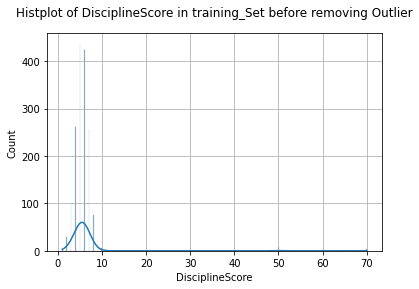

In [ ]:
# Deleting features with too many missing data
training_set = training_set.drop(columns=['PCR_11', 'PCR_15']) # In PCR_11 and PCR_15 columns more than 82% of the data in training_Set is missing
training_set = training_set.drop(columns=['Job']) # In Job column 27% of the data in training_Set is missing. In addition the data is spreading over a large amount of different (and non comparable) values.
# We Implements the same decisions of removing columns on validation_set and test_set:
validation_set = validation_set.drop(columns=['PCR_11', 'PCR_15', 'Job'])
test_set = test_set.drop(columns=['PCR_11', 'PCR_15', 'Job'])


# Deleting irrelevant features (mostly because no imputation)
training_set = training_set.drop(columns=['NrCousins', 'HouseholdExpenseOnPresents', 'HouseholdExpenseOnSocialGames',     \
                                          'HouseholdExpenseParkingTicketsPerYear', 'SocialMediaPerDay',                   \
                                          'StudingPerDay'])
validation_set = validation_set.drop(columns=['NrCousins', 'HouseholdExpenseOnPresents', 'HouseholdExpenseOnSocialGames',     \
                                              'HouseholdExpenseParkingTicketsPerYear', 'SocialMediaPerDay',                   \
                                              'StudingPerDay'])
test_set = test_set.drop(columns=['NrCousins', 'HouseholdExpenseOnPresents', 'HouseholdExpenseOnSocialGames',     \
                                  'HouseholdExpenseParkingTicketsPerYear', 'SocialMediaPerDay',                   \
                                  'StudingPerDay'])

# Deleting non-correlating featurs to 'Virus'/'SpreadLevel'/'Risk' (which are the lables)
training_set = training_set.drop(columns=['Address'])
validation_set = validation_set.drop(columns=['Address'])
test_set = test_set.drop(columns=['Address'])


#############################################
##### Fill missing values (nan, etc...) #####
#############################################

# Sex fill missing by distribution of Males and Females non-missing values
m, f, n = len(training_set[training_set.Sex == 0]), len(training_set[training_set.Sex == 1]), len(training_set[training_set.Sex == 'nan'])
m_f_percentage = (m / (m + f))
fill_m = m_f_percentage * n
sex_list = []
for x in training_set.Sex.to_list():
  if x == 'nan' and fill_m > 0:
    sex_list.append(0)
    fill_m -= 1
  elif x == 'nan':
    sex_list.append(1)
  else:
    sex_list.append(x)
training_set.Sex = sex_list

n = len(validation_set[validation_set.Sex == 'nan'])
fill_m = m_f_percentage * n
sex_list = []
for x in validation_set.Sex.to_list():
  if x == 'nan' and fill_m > 0:
    sex_list.append(0)
    fill_m -= 1
  elif x == 'nan':
    sex_list.append(1)
  else:
    sex_list.append(x)
validation_set.Sex = sex_list

n = len(test_set[test_set.Sex == 'nan'])
fill_m = m_f_percentage * n
sex_list = []
for x in test_set.Sex.to_list():
  if x == 'nan' and fill_m > 0:
    sex_list.append(0)
    fill_m -= 1
  elif x == 'nan':
    sex_list.append(1)
  else:
    sex_list.append(x)
test_set.Sex = sex_list


# AgeGroup fill missing by distibution of AgeGroup non-missing values on training_set
d = training_set.AgeGroup.value_counts(normalize=True)
missing = training_set['AgeGroup'].isna()
training_set.loc[missing,'AgeGroup'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['AgeGroup'].isna()
validation_set.loc[missing,'AgeGroup'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['AgeGroup'].isna()
test_set.loc[missing,'AgeGroup'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)

# BMI fill missing by distribution of BMI non-missing values on training_set
d = training_set.BMI.value_counts(normalize=True)
missing = training_set['BMI'].isna()
training_set.loc[missing,'BMI'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['BMI'].isna()
validation_set.loc[missing,'BMI'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = training_set['BMI'].isna()
training_set.loc[missing,'BMI'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)


# BloodType fill missing by distribution of BloodType non-missing values
d = training_set.BloodType.value_counts(normalize=True)
missing = training_set['BloodType'].isna()
training_set.loc[missing,'BloodType'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['BloodType'].isna()
validation_set.loc[missing,'BloodType'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['BloodType'].isna()
test_set.loc[missing,'BloodType'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)


# ConversatiosPerDay fill missing by distribution of ConversatiosPerDay non-missing values
d = training_set.ConversatiosPerDay.value_counts(normalize=True)
missing = training_set['ConversatiosPerDay'].isna()
training_set.loc[missing,'ConversatiosPerDay'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['ConversatiosPerDay'].isna()
validation_set.loc[missing,'ConversatiosPerDay'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['ConversatiosPerDay'].isna()
test_set.loc[missing,'ConversatiosPerDay'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)


# CurrentLocationLatitude fill missing with -1 (="not a location")
training_set.CurrentLocationLatitude = [-1 if str(x) == 'nan' else x for x in training_set.CurrentLocationLatitude.to_list()]
validation_set.CurrentLocationLatitude = [-1 if str(x) == 'nan' else x for x in validation_set.CurrentLocationLatitude.to_list()]
test_set.CurrentLocationLatitude = [-1 if str(x) == 'nan' else x for x in test_set.CurrentLocationLatitude.to_list()]

# CurrentLocationLongitude fill missing with -1 (="not a location")
training_set.CurrentLocationLongitude = [-1 if str(x) == 'nan' else x for x in training_set.CurrentLocationLongitude.to_list()]
validation_set.CurrentLocationLongitude = [-1 if str(x) == 'nan' else x for x in validation_set.CurrentLocationLongitude.to_list()]
test_set.CurrentLocationLongitude = [-1 if str(x) == 'nan' else x for x in test_set.CurrentLocationLongitude.to_list()]


# DateOfPCRTest fill missing by distribution of DateOfPCRTest non-missing values
d = training_set.DateOfPCRTest.value_counts(normalize=True)
missing = training_set['DateOfPCRTest'].isna()
training_set.loc[missing,'DateOfPCRTest'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['DateOfPCRTest'].isna()
validation_set.loc[missing,'DateOfPCRTest'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['DateOfPCRTest'].isna()
test_set.loc[missing,'DateOfPCRTest'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)


# DisciplineScore fill missing by distribution of DisciplineScore non-missing values
print("DisciplineScore:")
print("================")
print("Number of valid values in training_set: " + str(training_set.DisciplineScore.count()) + " out of " + str(training_set.DisciplineScore.shape[0]))
print("Value counts:")
print(training_set.DisciplineScore.value_counts())
g1 = sns.histplot(training_set.DisciplineScore, kde=True)
g1.set_title('Histplot of DisciplineScore in training_Set before removing Outlier', y=1.05)
g1.grid()

### part of 9. Outlier Detection

After removing Outliers and filling missing data:
Number of valid values in training_set: 1800 out of 1800
Value counts:
5.0     488
6.0     465
4.0     300
7.0     291
3.0     111
8.0      92
2.0      31
9.0      15
10.0      6
1.0       1
Name: DisciplineScore, dtype: int64
Histplot:


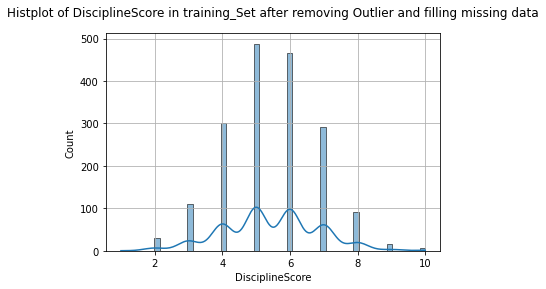

In [ ]:
# DisciplineScore Outlier detection
training_set.DisciplineScore = [x if x >= 0 and x <= 10 else float('nan') for x in training_set.DisciplineScore] # Replaces all Outliers with 'nan' for future manipulation
d = training_set.DisciplineScore.value_counts(normalize=True)
missing = training_set['DisciplineScore'].isna()
training_set.loc[missing,'DisciplineScore'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['DisciplineScore'].isna()
validation_set.loc[missing,'DisciplineScore'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['DisciplineScore'].isna()
test_set.loc[missing,'DisciplineScore'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)

print("After removing Outliers and filling missing data:")
print("Number of valid values in training_set: " + str(training_set.DisciplineScore.count()) + " out of " + str(training_set.DisciplineScore.shape[0]))
print("Value counts:")
print(training_set.DisciplineScore.value_counts())
print("Histplot:")
g2 = sns.histplot(training_set.DisciplineScore, kde=True)
g2.set_title('Histplot of DisciplineScore in training_Set after removing Outlier and filling missing data', y=1.05)
g2.grid()

### continue of 7. and 8.

In [ ]:
# HappinessScore fill missing by distribution of HappinessScore non-missing values
d = training_set.HappinessScore.value_counts(normalize=True)
missing = training_set['HappinessScore'].isna()
training_set.loc[missing,'HappinessScore'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['HappinessScore'].isna()
validation_set.loc[missing,'HappinessScore'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['HappinessScore'].isna()
test_set.loc[missing,'HappinessScore'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)

# MedicalCarePerYear fill missing by distribution of MedicalCarePerYear non-missing values
d = training_set.MedicalCarePerYear.value_counts(normalize=True)
missing = training_set['MedicalCarePerYear'].isna()
training_set.loc[missing,'MedicalCarePerYear'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['MedicalCarePerYear'].isna()
validation_set.loc[missing,'MedicalCarePerYear'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['MedicalCarePerYear'].isna()
test_set.loc[missing,'MedicalCarePerYear'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)

# PCRs fill missing by distribution of PCRs non-missing values
i, j = training_set.columns.get_loc('PCR_10'), training_set.columns.get_loc('PCR_95')
PCRs = training_set.columns.to_list()[i : j + 1]
for col_name in PCRs:
  d = training_set[col_name].value_counts(normalize=True)
  missing = training_set[col_name].isna()
  training_set.loc[missing,col_name] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

  missing = validation_set[col_name].isna()
  validation_set.loc[missing,col_name] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

  missing = test_set[col_name].isna()
  test_set.loc[missing,col_name] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)


# SocialActivitiesPerDay fill missing by distribution of SocialActivitiesPerDay non-missing values
d = training_set.SocialActivitiesPerDay.value_counts(normalize=True)
missing = training_set['SocialActivitiesPerDay'].isna()
training_set.loc[missing,'SocialActivitiesPerDay'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['SocialActivitiesPerDay'].isna()
validation_set.loc[missing,'SocialActivitiesPerDay'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['SocialActivitiesPerDay'].isna()
test_set.loc[missing,'SocialActivitiesPerDay'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)

# SportsPerDay fill missing by distribution of SportsPerDay non-missing values
d = training_set.SportsPerDay.value_counts(normalize=True)
missing = training_set['SportsPerDay'].isna()
training_set.loc[missing,'SportsPerDay'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['SportsPerDay'].isna()
validation_set.loc[missing,'SportsPerDay'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['SportsPerDay'].isna()
test_set.loc[missing,'SportsPerDay'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)


# StepsPerYear fill missing by distribution of StepsPerYear non-missing values
d = training_set.StepsPerYear.value_counts(normalize=True)
missing = training_set['StepsPerYear'].isna()
training_set.loc[missing,'StepsPerYear'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['StepsPerYear'].isna()
validation_set.loc[missing,'StepsPerYear'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['StepsPerYear'].isna()
test_set.loc[missing,'StepsPerYear'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)

### continue of 9.

BMI Outlier detection:


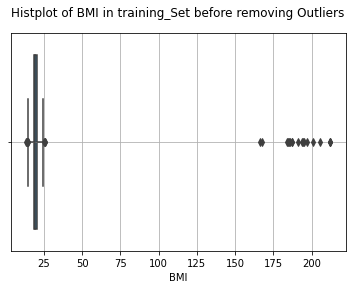

In [ ]:
#############################################
#### Outlier Detection and normalization ####
#############################################

print("BMI Outlier detection:")
print("================")
plot = sns.boxplot(data = training_set, x = 'BMI')
plot.set_title('Histplot of BMI in training_Set before removing Outliers', y=1.05)
plot.grid()

BMI after removing Outliers:
Boxplot:


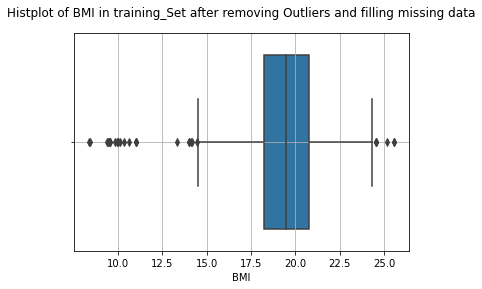

In [ ]:
mean, std = np.mean(training_set.BMI.to_list()), np.std(training_set.BMI.to_list())
training_set.BMI = [(x - mean) / std if x > 50 else x for x in training_set.BMI.to_list()]
validation_set.BMI = [(x - mean) / std if x > 50 else x for x in validation_set.BMI.to_list()]
test_set.BMI = [(x - mean) / std if x > 50 else x for x in test_set.BMI.to_list()]

print("BMI after removing Outliers:")
print("Boxplot:")
plot = sns.boxplot(data = training_set, x = 'BMI')
plot.set_title('Histplot of BMI in training_Set after removing Outliers and filling missing data', y=1.05)
plot.grid()

For example we will plot the Boxplot of PCR_19 and PCR_89 before Outlier detection and filling missing data and after that:

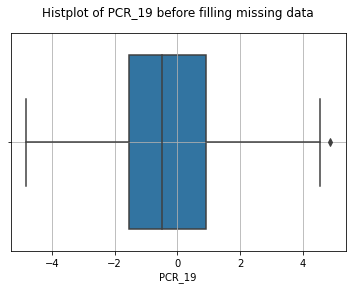

In [ ]:
plot1 = sns.boxplot(data = training_set, x = 'PCR_19')
plot1.set_title('Histplot of PCR_19 before filling missing data', y=1.05)
plot1.grid()

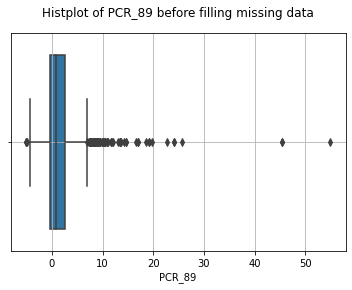

In [ ]:
plot2 = sns.boxplot(data = training_set, x = 'PCR_89')
plot2.set_title('Histplot of PCR_89 before filling missing data', y=1.05)
plot2.grid()

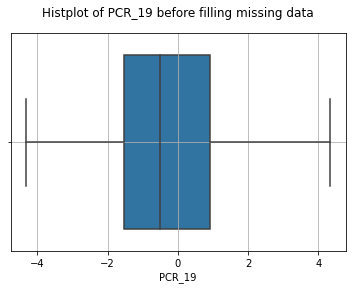

In [ ]:
# PCRs fill missing by distribution of PCRs non-missing values
i, j = training_set.columns.get_loc('PCR_10'), training_set.columns.get_loc('PCR_95')
PCRs = training_set.columns.to_list()[i : j + 1]
for col_name in PCRs:
  mean, std = np.mean(training_set[col_name].to_list()), np.std(training_set[col_name].to_list())
  if std > 4:
    training_set = training_set.drop(columns=[col_name])
    validation_set = validation_set.drop(columns=[col_name])
    test_set = test_set.drop(columns=[col_name])
  else:
    training_set[col_name] = [x if (x > -std * 2.5 and x < std * 2.5) else ((x - mean) / std) for x in training_set[col_name].to_list()]
    validation_set[col_name] = [x if (x > -std * 2.5 and x < std * 2.5) else ((x - mean) / std) for x in validation_set[col_name].to_list()]
    test_set[col_name] = [x if (x > -std * 2.5 and x < std * 2.5) else ((x - mean) / std) for x in test_set[col_name].to_list()]

plot1 = sns.boxplot(data = training_set, x = 'PCR_19')
plot1.set_title('Histplot of PCR_19 before filling missing data', y=1.05)
plot1.grid()

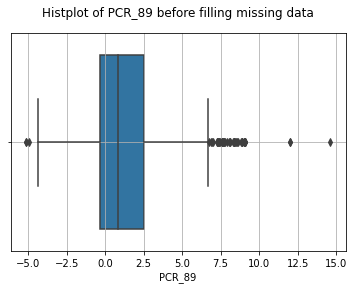

In [ ]:
plot2 = sns.boxplot(data = training_set, x = 'PCR_89')
plot2.set_title('Histplot of PCR_89 before filling missing data', y=1.05)
plot2.grid()

SocialActivitiesPerDay:
Plots:


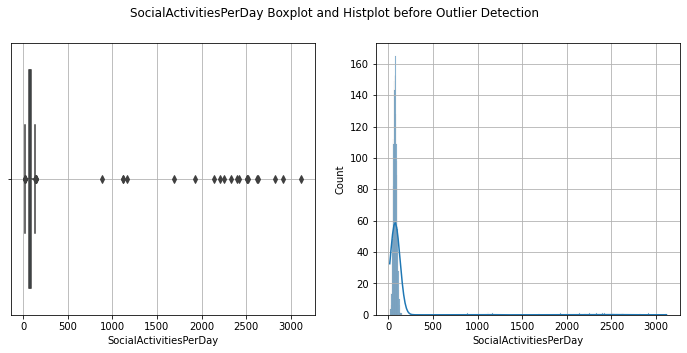

In [ ]:
# SocialActivitiesPerDay Outlier detection and normalization
print("SocialActivitiesPerDay:")
print("================")
print("Plots:")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('SocialActivitiesPerDay Boxplot and Histplot before Outlier Detection')
g1 = sns.boxplot(data = training_set, x='SocialActivitiesPerDay', ax=axes[0])
g1.grid()
g2 = sns.histplot(training_set.SocialActivitiesPerDay, kde=True, ax=axes[1])
g2.grid()

SocialActivitiesPerDay after removing Outliers:
Plots:


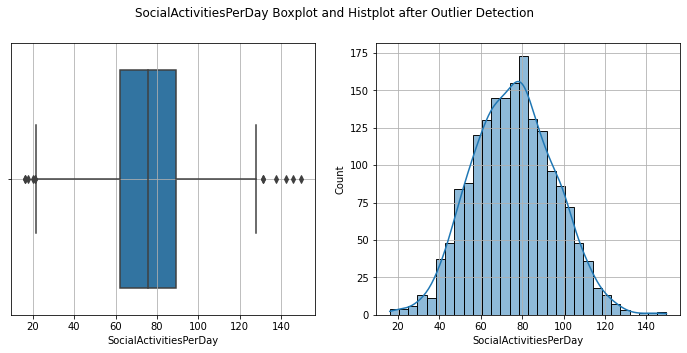

In [ ]:
# SocialActivitiesPerDay Outlier detection and normalization
training_set.SocialActivitiesPerDay = [x if x <= 200 else float('nan') for x in training_set.SocialActivitiesPerDay] # Replaces all Outliers with 'nan' for future manipulation
d = training_set.SocialActivitiesPerDay.value_counts(normalize=True)
missing = training_set['SocialActivitiesPerDay'].isna()
training_set.loc[missing,'SocialActivitiesPerDay'] = np.random.choice(d.index, size=len(training_set[missing]),p=d.values)

missing = validation_set['SocialActivitiesPerDay'].isna()
validation_set.loc[missing,'SocialActivitiesPerDay'] = np.random.choice(d.index, size=len(validation_set[missing]),p=d.values)

missing = test_set['SocialActivitiesPerDay'].isna()
test_set.loc[missing,'SocialActivitiesPerDay'] = np.random.choice(d.index, size=len(test_set[missing]),p=d.values)

print("SocialActivitiesPerDay after removing Outliers:")
print("Plots:")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('SocialActivitiesPerDay Boxplot and Histplot after Outlier Detection')
g1 = sns.boxplot(data = training_set, x='SocialActivitiesPerDay', ax=axes[0])
g1.grid()
g2 = sns.histplot(training_set.SocialActivitiesPerDay, kde=True, ax=axes[1])
g2.grid()

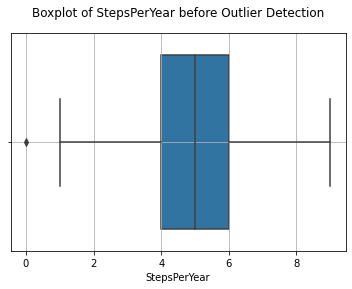

In [ ]:
# StepsPerYear Outlier detection and normalization
g1 = sns.boxplot(data = training_set, x = 'StepsPerYear')
g1.set_title('Boxplot of StepsPerYear before Outlier Detection', y=1.05)
g1.grid()

4.733888888888889
1.5073031063196902


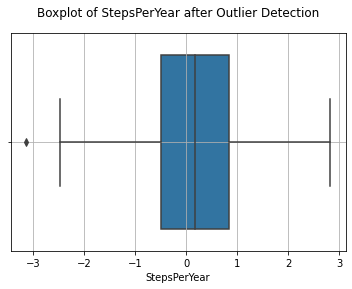

In [ ]:
# StepsPerYear Outlier detection
mean, std = np.mean(training_set.StepsPerYear.to_list()), np.std(training_set.StepsPerYear.to_list())
print(mean)
print(std)
training_set.StepsPerYear = [((x - mean) / std) for x in training_set.StepsPerYear.to_list()]

g1 = sns.boxplot(data = training_set, x = 'StepsPerYear')
g1.set_title('Boxplot of StepsPerYear after Outlier Detection', y=1.05)
g1.grid()

In [ ]:
# Generalization of BMI to three different possible values: 0 - Underweight, 1 - Normal, 2 - Overweight
#sns.histplot(training_set.BMI, kde=True)
training_set.BMI = [0 if x < 18.5 else 1 if 18.5 <= x < 25 else 2 for x in training_set.BMI] # 0 - Underweight, 1 - Normal, 2 - Overweight
validation_set.BMI =  [0 if x < 18.5 else 1 if 18.5 <= x < 25 else 2 for x in validation_set.BMI]
test_set.BMI =  [0 if x < 18.5 else 1 if 18.5 <= x < 25 else 2 for x in test_set.BMI]
#print(BMI_list)
#sns.histplot(df.BMI[df.BMI < 200], kde=True)
print("Checkpoint for DataFrame:")
print(training_set.count())

Checkpoint for DataFrame:
ID                                  1800
AgeGroup                            1800
BMI                                 1800
BloodType                           1800
ConversatiosPerDay                  1800
CurrentLocationLatitude             1800
CurrentLocationLongitude            1800
DateOfPCRTest                       1800
DisciplineScore                     1800
HappinessScore                      1800
MedicalCarePerYear                  1800
PCR_19                              1800
PCR_7                               1800
PCR_72                              1800
PCR_89                              1800
PCR_95                              1800
Self_declaration_of_Illness_Form    1800
Sex                                 1800
SocialActivitiesPerDay              1800
SportsPerDay                        1800
StepsPerYear                        1800
Virus                               1800
SpreadLevel                         1800
Risk                           

# Part 3 - Feature Selection

### 13.1. Correlation Table (Matrix) for all suitable features

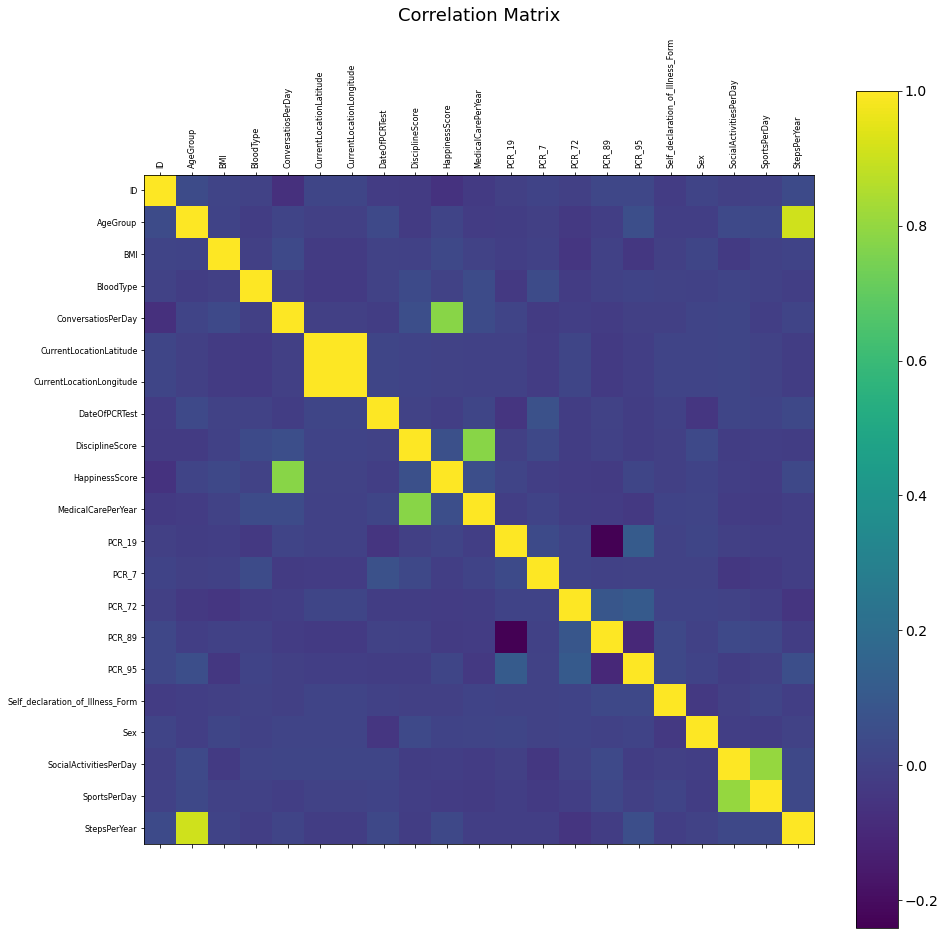

In [ ]:
# Taking only the features from the training_set
x_train = training_set.iloc[: , 0 : training_set.columns.get_loc('Virus')]
x_train_column_names = x_train.columns

# columns_for_correlation = training_set.columns
f = plt.figure(figsize=(15, 15))
plt.matshow(x_train.corr(), fignum=f.number)
plt.xticks(range(len(x_train_column_names)), x_train_column_names, fontsize=8, rotation=90)
plt.yticks(range(len(x_train_column_names)), x_train_column_names, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
_ = plt.title('Correlation Matrix', fontsize=18, pad=120)

After generating the Correlation Matrix, we decided to analyze the pairs with correlation bigger than 0.75.

In [ ]:
for col1 in x_train_column_names[:-1]:
  for col2 in x_train_column_names[x_train_column_names.to_list().index(col1) + 1:]:
    c = x_train.corr()[col1][col2]
    if c > 0.75:
      print("Correlation between", col1, "and", col2, "is: {:.3f}".format(c))

Correlation between AgeGroup and StepsPerYear is: 0.913
Correlation between ConversatiosPerDay and HappinessScore is: 0.781
Correlation between CurrentLocationLatitude and CurrentLocationLongitude is: 1.000
Correlation between DisciplineScore and MedicalCarePerYear is: 0.777
Correlation between SocialActivitiesPerDay and SportsPerDay is: 0.806


So, the selected pairs of features, to analyze using histograms, are:

1. AgeGroup - StepsPerYear

2. ConversatiosPerDay - HappinessScore

3. CurrentLocationLatitude - CurrentLocationLongitude

4. DisciplineScore - MedicalCarePerYear

5. SocialActivitiesPerDay - SportsPerDay

### 13.2. Analyze correlated features using histograms

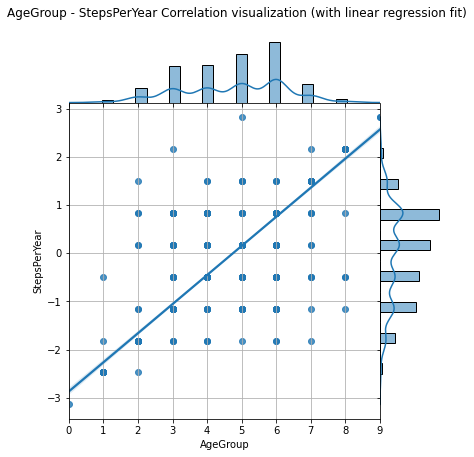

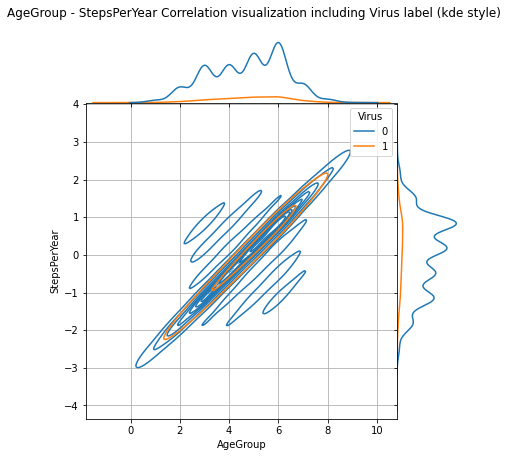

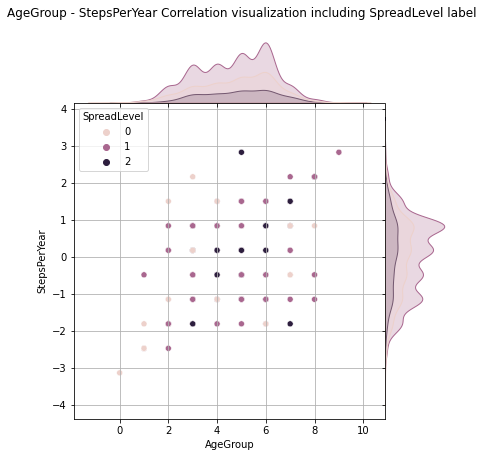

In [ ]:
# AgeGroup - StepsPerYear
g1 = sns.jointplot(data=training_set, x="AgeGroup", y="StepsPerYear", space=0, kind='reg')
g1.ax_joint.grid()
g1.fig.suptitle('AgeGroup - StepsPerYear Correlation visualization (with linear regression fit)', y=1.05)

g2 = sns.jointplot(data=training_set, x="AgeGroup", y="StepsPerYear", hue="Virus", space=0, kind='kde')
g2.ax_joint.grid()
g2.fig.suptitle('AgeGroup - StepsPerYear Correlation visualization including Virus label (kde style)', y=1.05)

g3 = sns.jointplot(data=training_set, x="AgeGroup", y="StepsPerYear", hue="SpreadLevel", space=0)
g3.ax_joint.grid()
g3.fig.suptitle('AgeGroup - StepsPerYear Correlation visualization including SpreadLevel label', y=1.05)

training_set = training_set.drop(columns=['StepsPerYear'])
validation_set = validation_set.drop(columns=['StepsPerYear'])
test_set = test_set.drop(columns=['StepsPerYear'])

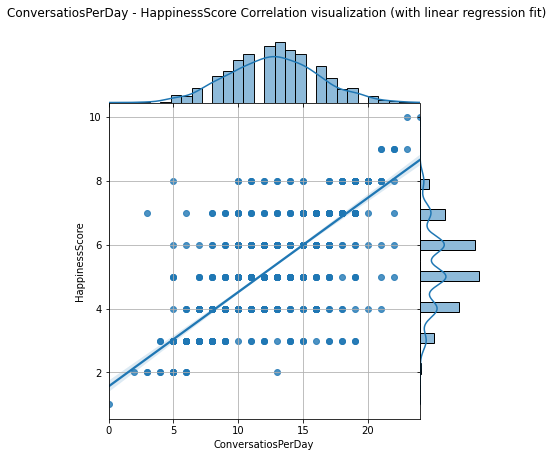

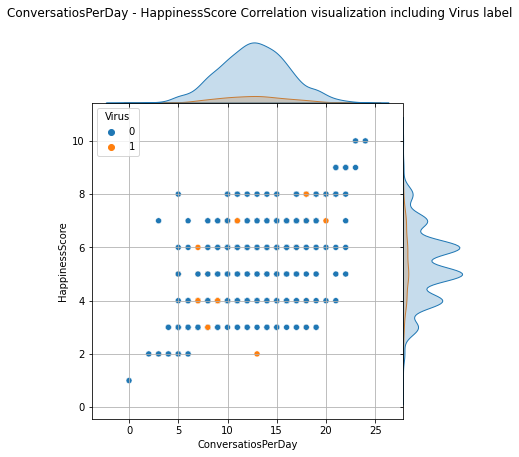

In [ ]:
# ConversatiosPerDay - HappinessScore
g1 = sns.jointplot(data=training_set, x="ConversatiosPerDay", y="HappinessScore", space=0, kind='reg')
g1.ax_joint.grid()
g1.fig.suptitle('ConversatiosPerDay - HappinessScore Correlation visualization (with linear regression fit)', y=1.05)

g2 = sns.jointplot(data=training_set, x="ConversatiosPerDay", y="HappinessScore", hue="Virus", space=0)
g2.ax_joint.grid()
g2.fig.suptitle('ConversatiosPerDay - HappinessScore Correlation visualization including Virus label', y=1.05)

training_set = training_set.drop(columns=['ConversatiosPerDay'])
validation_set = validation_set.drop(columns=['ConversatiosPerDay'])
test_set = test_set.drop(columns=['ConversatiosPerDay'])

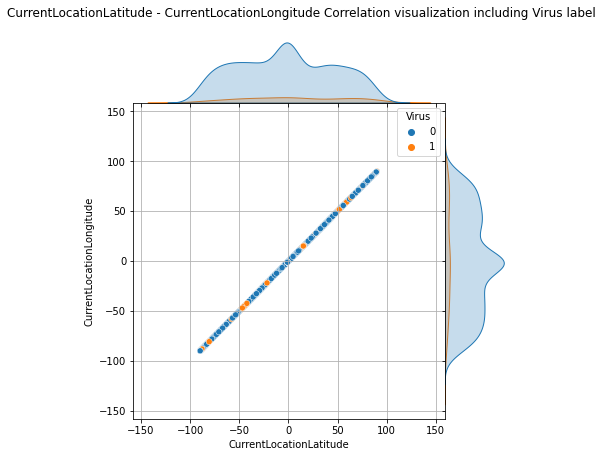

In [ ]:
# CurrentLocationLatitude - CurrentLocationLongitude
g1 = sns.jointplot(data=training_set, x="CurrentLocationLatitude", y="CurrentLocationLongitude", hue="Virus", space=0)
g1.ax_joint.grid()
g1.fig.suptitle('CurrentLocationLatitude - CurrentLocationLongitude Correlation visualization including Virus label', y=1.05)

training_set = training_set.drop(columns=['CurrentLocationLongitude'])
validation_set = validation_set.drop(columns=['CurrentLocationLongitude'])
test_set = test_set.drop(columns=['CurrentLocationLongitude'])

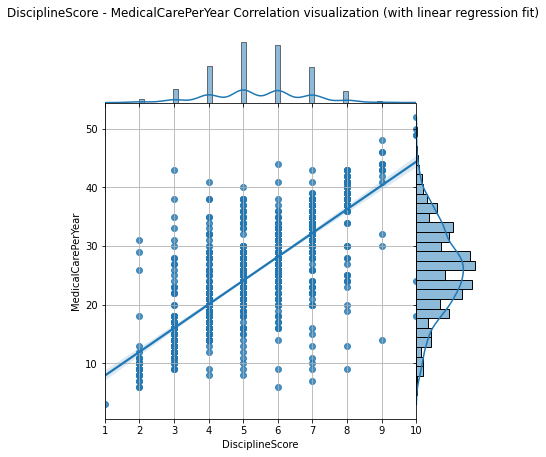

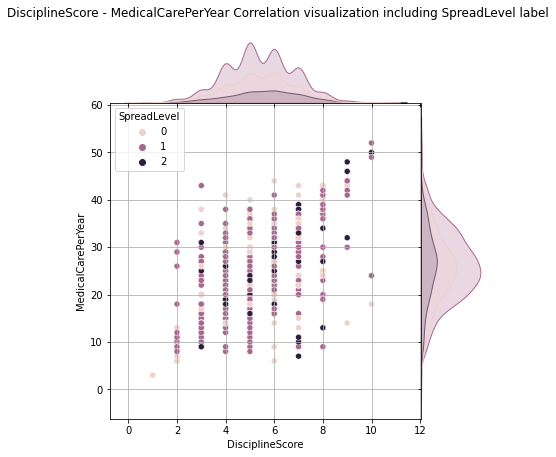

In [ ]:
# DisciplineScore - MedicalCarePerYear
g1 = sns.jointplot(data=training_set, x="DisciplineScore", y="MedicalCarePerYear", space=0, kind='reg')
g1.ax_joint.grid()
g1.fig.suptitle('DisciplineScore - MedicalCarePerYear Correlation visualization (with linear regression fit)', y=1.05)

g2 = sns.jointplot(data=training_set, x="DisciplineScore", y="MedicalCarePerYear", hue="SpreadLevel", space=0)
g2.ax_joint.grid()
g2.fig.suptitle('DisciplineScore - MedicalCarePerYear Correlation visualization including SpreadLevel label', y=1.05)

training_set = training_set.drop(columns=['MedicalCarePerYear'])
validation_set = validation_set.drop(columns=['MedicalCarePerYear'])
test_set = test_set.drop(columns=['MedicalCarePerYear'])

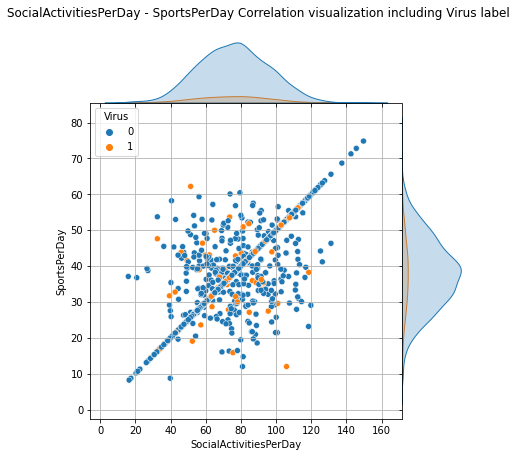

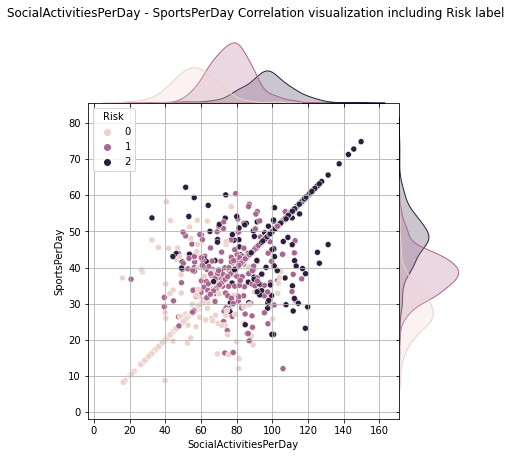

In [ ]:
# SocialActivitiesPerDay - SportsPerDay
g1 = sns.jointplot(data=training_set, x="SocialActivitiesPerDay", y="SportsPerDay", hue="Virus", space=0)
g1.ax_joint.grid()
g1.fig.suptitle('SocialActivitiesPerDay - SportsPerDay Correlation visualization including Virus label', y=1.05)

g2 = sns.jointplot(data=training_set, x="SocialActivitiesPerDay", y="SportsPerDay", hue="Risk", space=0)
g2.ax_joint.grid()
g2.fig.suptitle('SocialActivitiesPerDay - SportsPerDay Correlation visualization including Risk label', y=1.05)

training_set = training_set.drop(columns=['SocialActivitiesPerDay'])
validation_set = validation_set.drop(columns=['SocialActivitiesPerDay'])
test_set = test_set.drop(columns=['SocialActivitiesPerDay'])

### 14. a. Wrraping and removing less informative features

In [ ]:
# Import sklearn libraries (specifically here: classifiers and wrapper methods)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
# Select From Model with DecisionTree as Classifier
x_train = training_set.iloc[: , 0 : training_set.columns.get_loc('Virus')]
y_train = training_set.iloc[: , training_set.columns.get_loc('Virus') : ]
sel = SelectFromModel(DecisionTreeClassifier(criterion='entropy'), threshold=-np.inf, max_features=6).fit(x_train, y_train)
indices = sel.get_support(indices=True)
best_features_decision_tree = set([x_train.columns[i] for i in indices])
print("The 6 best features by Select From Model with DecisionTree as Classifier are:")
print(best_features_decision_tree)

The 6 best features by Select From Model with DecisionTree as Classifier are:
{'PCR_7', 'SportsPerDay', 'DisciplineScore', 'BMI', 'PCR_72', 'HappinessScore'}


In [ ]:
# Sequential Feature Selection with KNN as Classifier
knn = KNeighborsClassifier(n_neighbors=20)
sel = SequentialFeatureSelector(knn, n_features_to_select=7)

best_features_knn = set([])

sel.fit(x_train, y_train['Virus'])
indices = sel.get_support(indices=True)
best_features_knn = best_features_knn | set([x_train.columns[i] for i in indices])

sel.fit(x_train, y_train['SpreadLevel'])
indices = sel.get_support(indices=True)
best_features_knn = best_features_knn | set([x_train.columns[i] for i in indices])

sel.fit(x_train, y_train['Risk'])
indices = sel.get_support(indices=True)
best_features_knn = best_features_knn | set([x_train.columns[i] for i in indices])


print("The best features by Sequential Feature Selection with KNearestNeighbors as Classifier are:")
print(best_features_knn)

The best features by Sequential Feature Selection with KNearestNeighbors as Classifier are:
{'AgeGroup', 'PCR_7', 'Sex', 'SportsPerDay', 'Self_declaration_of_Illness_Form', 'DisciplineScore', 'PCR_89', 'PCR_19', 'BMI', 'PCR_72', 'HappinessScore'}


In [ ]:
best_features = best_features_decision_tree | best_features_knn
features_to_Remove = set(x_train.columns) - best_features
print("The Union of the best features by Select From Model with DecisionTree as Classifier and by Sequential Feature Selection with KNearestNeighbors as Classifierare are:")
print(best_features)
print("So the features that we are going to remove after this step are:")
print(features_to_Remove)

The Union of the best features by Select From Model with DecisionTree as Classifier and by Sequential Feature Selection with KNearestNeighbors as Classifierare are:
{'DisciplineScore', 'PCR_19', 'BMI', 'PCR_72', 'AgeGroup', 'PCR_7', 'Sex', 'SportsPerDay', 'Self_declaration_of_Illness_Form', 'PCR_89', 'HappinessScore'}
So the features that we are going to remove after this step are:
{'BloodType', 'PCR_95', 'CurrentLocationLatitude', 'DateOfPCRTest', 'ID'}


In [ ]:
# Removing the features of 14.a. section
print("Number of features before 14.a. section:")
print(x_train.shape[1])

training_set = training_set.drop(columns=features_to_Remove)
validation_set = validation_set.drop(columns=features_to_Remove)
test_set = test_set.drop(columns=features_to_Remove)

print("Number of features after 14.a. section:")
print(x_train.drop(columns=features_to_Remove).shape[1])

Number of features before 14.a. section:
16
Number of features after 14.a. section:
11


### 14. b. Univariate and Bi-Variate analysis

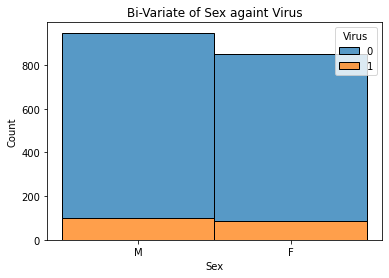

In [ ]:
df_to_plot = training_set[['Sex', 'Virus']].copy()
df_to_plot.Sex = ['M' if x == 0 else 'F' for x in df_to_plot.Sex]

_ = sns.histplot(df_to_plot, x="Sex", hue="Virus", multiple="stack", bins=2, binwidth=0.3).set_title('Bi-Variate of Sex againt Virus')

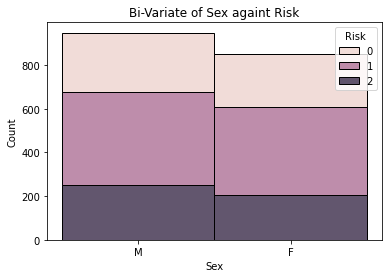

In [ ]:
df_to_plot = training_set[['Sex', 'Risk']].copy()
df_to_plot.Sex = ['M' if x == 0 else 'F' for x in df_to_plot.Sex]

_ = sns.histplot(df_to_plot, x="Sex", hue="Risk", multiple="stack", bins=2, binwidth=0.3).set_title('Bi-Variate of Sex againt Risk')

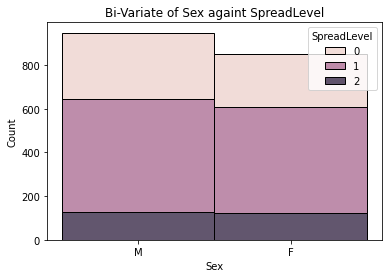

In [ ]:
df_to_plot = training_set[['Sex', 'SpreadLevel']].copy()
df_to_plot.Sex = ['M' if x == 0 else 'F' for x in df_to_plot.Sex]

_ = sns.histplot(df_to_plot, x="Sex", hue="SpreadLevel", multiple="stack", bins=2, binwidth=0.3).set_title('Bi-Variate of Sex againt SpreadLevel')

In [ ]:
# Removing of Sex feature after seeng no trend it makes
training_set = training_set.drop(columns='Sex')
validation_set = validation_set.drop(columns='Sex')
test_set = test_set.drop(columns='Sex')

### 15. In the report PDF

### 16. save the results

# Download the CSVs from Colab

In [ ]:
from google.colab import files

### We saved the DataFrames for all features and selected features, both including the labels

selected_training_set_path = "selected_training_set.csv"
training_set.to_csv(selected_training_set_path)
files.download(selected_training_set_path)

selected_validation_set_path = "selected_validation_set.csv"
validation_set.to_csv(selected_validation_set_path)
files.download(selected_validation_set_path)

selected_test_set_path = "selected_test_set.csv"
test_set.to_csv(selected_test_set_path)
files.download(selected_test_set_path)

all_features_df = pd.read_csv(csv_file_path, sep=',', header=0)
# splitting the original DataFrame (with all features) to train, validation and test
all_features_training_set, all_features_test_set = train_test_split(all_features_df, train_size = 0.8, random_state=11)

all_features_training_set, all_features_validation_set = train_test_split(all_features_training_set, train_size = 0.75, random_state=11)

all_features_training_set_path = "all_features_training_set.csv"
all_features_training_set.to_csv(all_features_training_set_path)
files.download(all_features_training_set_path)

all_features_validation_set_path = "all_features_validation_set.csv"
all_features_validation_set.to_csv(all_features_validation_set_path)
files.download(all_features_validation_set_path)

all_features_test_set_path = "all_features_test_set.csv"
all_features_test_set.to_csv(all_features_test_set_path)
files.download(all_features_test_set_path)

print("selected_training_set shape: ", training_set.shape)
print("selected_validation_set shape: ", validation_set.shape)
print("selected_test_set shape: ", test_set.shape)

print("all_features_training_set shape: ", all_features_training_set.shape)
print("all_features_validation_set shape: ", all_features_validation_set.shape)
print("all_features_test_set shape: ", all_features_test_set.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

selected_training_set shape:  (1800, 13)
selected_validation_set shape:  (600, 13)
selected_test_set shape:  (600, 13)
all_features_training_set shape:  (1800, 43)
all_features_validation_set shape:  (600, 43)
all_features_test_set shape:  (600, 43)
